In [1]:
import numpy as np
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# set to test image directory
TEST_DIR = '/data_service/source_datasets/cifar_images/images_test'

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tqdm import tqdm
# get test image paths
filenames = []
for f_name in tqdm(os.listdir(TEST_DIR)):
    if os.path.splitext(f_name)[-1] == '.png':
        filenames.append(os.path.join(TEST_DIR, f_name))


100%|██████████| 10000/10000 [00:00<00:00, 165617.15it/s]


In [3]:
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import lab2rgb, rgb2lab

In [5]:
# gpu config
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

KTF.set_session(sess)

In [6]:
from models.UnetColorizer import UnetColorizer, unet

# initialize colorizer and load model
colorizer = UnetColorizer(model=unet(1, 2))
colorizer.load('unet_20.model')

In [7]:
def get_gray_rgb(x):
    batch_size = x.shape[0]
    ret = []
    for batch_cnt in range(batch_size):
        l_channel = np.zeros((32, 32, 3))
        l_channel[:,:,0] = x[batch_cnt, :, :, 0]
        
        # reverted from norm
        l_channel = (l_channel * [100, 255, 255]) - [0, 128, 128]
        
        # reset the last two channel
        l_channel[:, :, 1:] = 0
        l_channel = lab2rgb(l_channel)

        l_channel = l_channel * [255, 255, 255]
        l_channel = l_channel.astype(np.uint8)
        
        ret.append(l_channel)
    return ret

def get_rgb(x, y):
    assert x.shape[0] == y.shape[0]
    batch_size = x.shape[0]
    ret = []
    
    for batch_cnt in range(batch_size):

        predicted_img = np.zeros((32, 32, 3))
        predicted_img[:,:,0] = x[batch_cnt, :, :, 0]  # light channel stay same
        predicted_img[:,:,1:] = y[batch_cnt]  # fill the last channels with predicted values

        predicted_img = (predicted_img * [100, 255, 255]) - [0, 128, 128]   # reverted from norm

        rgb_predicted = lab2rgb(predicted_img)  # convert lab to rgb
        rgb_predicted = rgb_predicted * [255, 255, 255]
        rgb_predicted = rgb_predicted.astype(np.uint8)
        ret.append(rgb_predicted)
    return ret

In [8]:
from PIL import Image

def save_result(save_dir, batch_i, gray_images, fake_images, original_images):
    assert len(gray_images) == len(fake_images) == len(original_images)

    batch_size = len(rgb_predict)
    
    # init image with size(width, height)
    generated_image = Image.new('RGB', (32*3, 32*batch_size))

    for batch_cnt in range(batch_size):
        gray = Image.fromarray(gray_images[batch_cnt])
        fake = Image.fromarray(fake_images[batch_cnt])
        original = Image.fromarray(original_images[batch_cnt])
        
        generated_image.paste(gray, (0, batch_cnt*32, 32, (batch_cnt+1)*32))
        generated_image.paste(fake, (32, batch_cnt*32, 32*2, (batch_cnt+1)*32))
        generated_image.paste(original, (32*2, batch_cnt*32, 32*3, (batch_cnt+1)*32))
    
    generated_image.save(save_dir + "/Unet_%d.jpg" % batch_i, quality=95)


In [12]:
from Dataset import CifarGenerator

batch_size = 16  # test in batches
data_generator = CifarGenerator(img_dir=TEST_DIR, batch_size=batch_size, color_space='LAB')

SAVED_DIR = './UnetRes'
for batch_cnt, (x, y) in enumerate(tqdm(data_generator)):
    fake_y = colorizer.predict(x)
    
    rgb_gray = get_gray_rgb(x)
    rgb_predict = get_rgb(x, fake_y)
    rgb_original = get_rgb(x, y)
    
    save_result(SAVED_DIR, batch_cnt, rgb_gray, rgb_predict, rgb_original)
    

  0%|          | 0/625 [00:00<?, ?it/s]


AttributeError: type object 'Image' has no attribute 'new'

Text(0.5,1,'ground truth image')

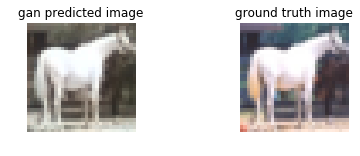

In [17]:
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(7, 2))

# ax = fig.add_subplot(1, 2, 1)
# ax.imshow(rgb); ax.axis("off")
# ax.set_title("gan predicted image")

# img = img_to_array(load_img(f_name, target_size=(32, 32))) / 255
# ax = fig.add_subplot(1, 2, 2)
# ax.imshow(img); ax.axis("off")
# ax.set_title("ground truth image")